# 準備

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import functools
from sklearn.ensemble import RandomForestRegressor
from tqdm.auto import tqdm
import itertools

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_columns', None)

# 読み込み

In [ ]:
# 株価データ
price_df = pd.read_parquet('../input/train_stock_price_top500.parquet.zstd')
# 銘柄マスタ
list_df = pd.read_parquet('../input/stock_list_top500.parquet.zstd')
# 東証売買内訳データ
trends_df = pd.read_parquet('../input/market_trends_top500.parquet.zstd')

In [ ]:
# データの確認
display(price_df)
display(list_df)
display(trends_df)

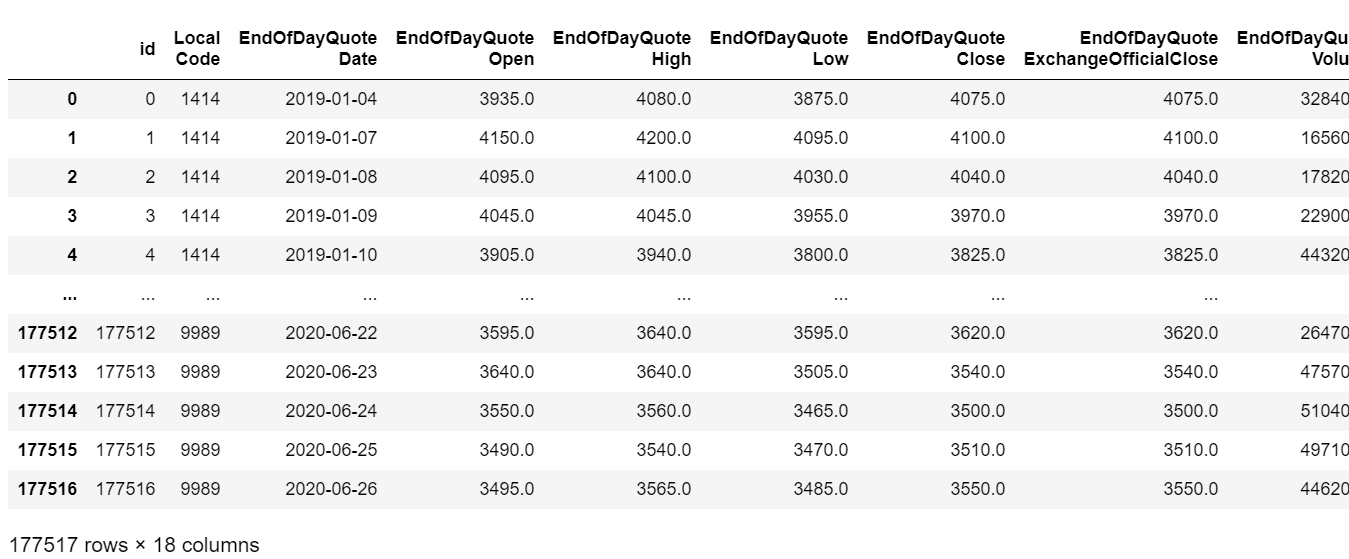
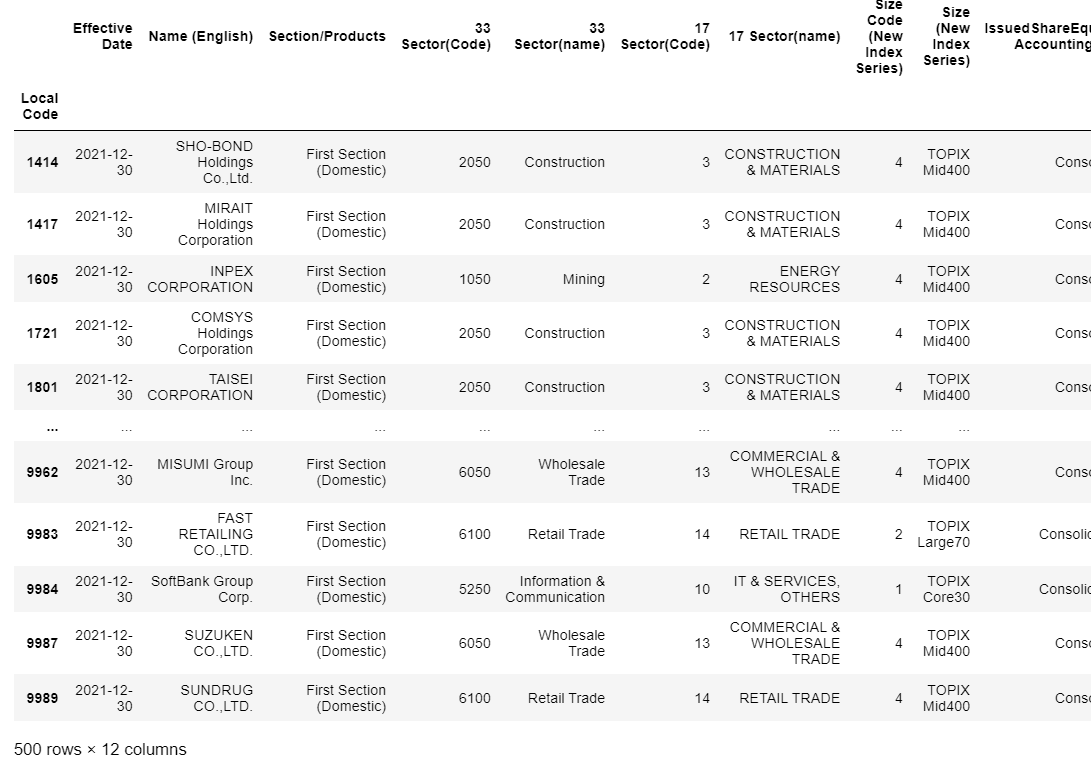
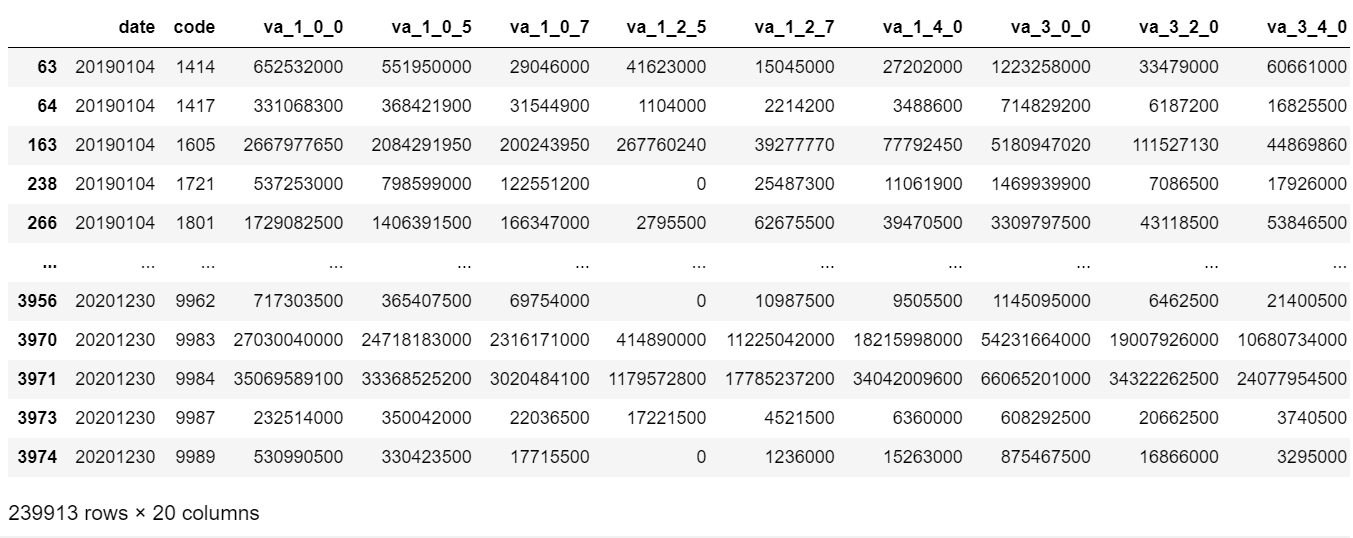

# データセットの可視化

In [ ]:
# 株価データと銘柄リストデータの結合
price_df.loc[:, "datetime"] = pd.to_datetime(price_df.loc[:, "EndOfDayQuote Date"], format="%Y-%m-%d")
price_df.set_index("datetime", inplace=True)
# 作業用に株価データと銘柄リストデータを内部結合する
df_list_n_price = pd.merge(list_df, price_df.reset_index(), how='inner', on="Local Code")

# 銘柄・株価データと東証売買内訳データを結合する
trends_df.loc[:, "datetime"] = pd.to_datetime(trends_df.loc[:, "date"], format="%Y%m%d")
trends_df.set_index("datetime", inplace=True)
# 銘柄・株価データに存在していて、東証売買内訳データに存在しない銘柄がないため、銘柄・株価データを主としてデータを結合する
work_df_org = pd.merge(df_list_n_price, trends_df, how="left", left_on=["datetime", "Local Code"], right_on=["datetime", "code"])
# indexの設定
work_df_org.set_index("datetime", inplace=True)

In [ ]:
# 市場区分別の銘柄数
print("------------------市場区分別の銘柄数------------------")
list_df.reset_index().groupby('Section/Products').count()['Local Code'].sort_values(ascending=False).plot.bar()
plt.show()
# セクター別の銘柄数
print("------------------セクター別の銘柄数------------------")
list_df.reset_index().groupby('33 Sector(name)').count()['Local Code'].sort_values(ascending=False).plot.bar()
plt.show()
# 発行済株式数の分布
print("------------------発行済株式数の分布------------------")
plt.hist(list_df.reset_index()['IssuedShareEquityQuote IssuedShare'],
        bins=300)
plt.show()
# 株価の分布（2019-01-04）
print("------------------株価の分布------------------")
plt.hist(df_list_n_price[df_list_n_price['datetime']=='2019-01-04']['EndOfDayQuote ExchangeOfficialClose'],
        bins=300)
plt.show()
# 売買の約定代金の分布（2019-01-04）
print("------------------売買の約定代金の分布------------------")
df_list_n_price['TradingValue'] = df_list_n_price['EndOfDayQuote VWAP'] * df_list_n_price['EndOfDayQuote Volume']
plt.hist(df_list_n_price[df_list_n_price['datetime']=='2019-01-04']['TradingValue'],
        bins=300)
plt.show()

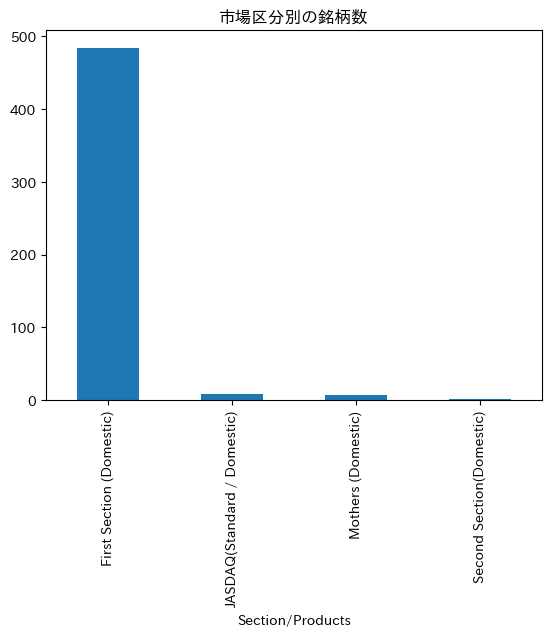
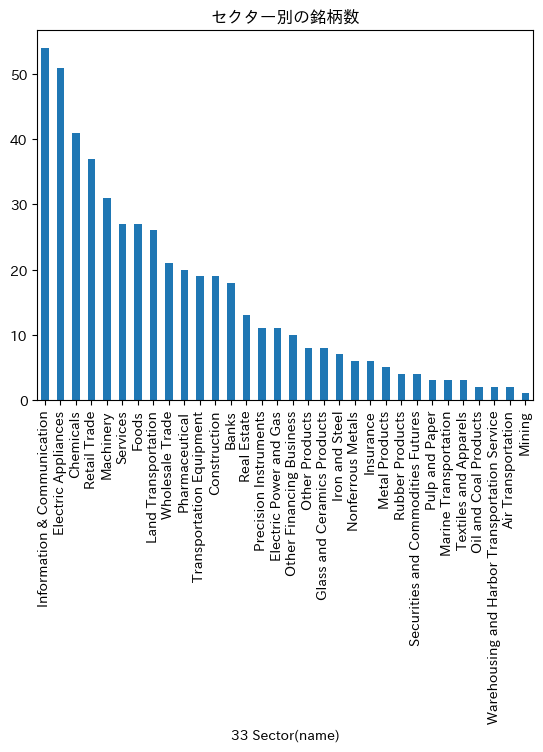
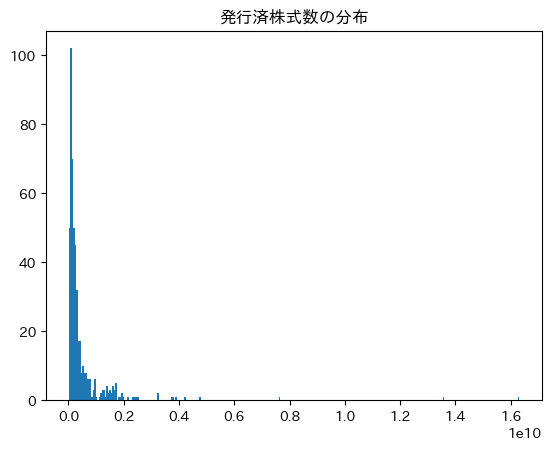
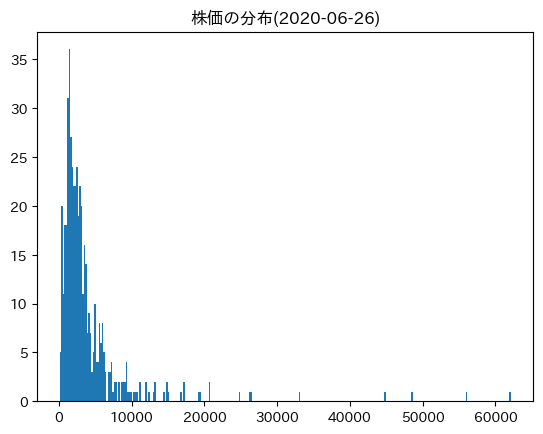
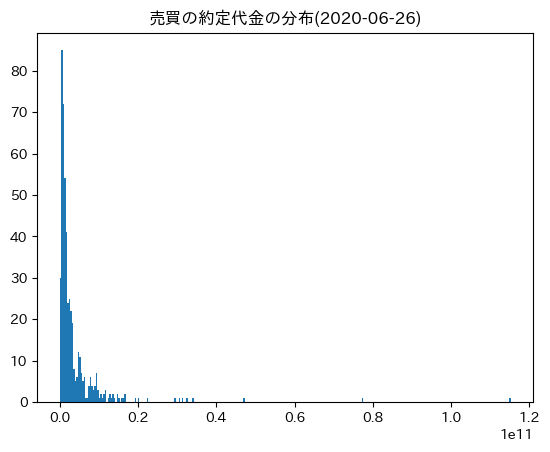

In [ ]:
# 作業用に結合データをコピー
work_df = work_df_org.copy()

# EDA

In [ ]:
# 「信用新規買いの約定代金」に対して当日の始値から終値の価格変化率の順位相関を2019/2020年の時系列的にプロット

# 当日の始値から終値の変化率を計算
work_df.loc[:, "intra_return"] = work_df[["EndOfDayQuote Open", "EndOfDayQuote ExchangeOfficialClose"]].pct_change(axis=1).fillna(0).iloc[:, 1] * 100

# va_3_2_0

# 日次の順位相関の時系列を計算する
# 営業日を取得
business_days = sorted(work_df.index.unique())

# 順位相関の保存用
daily_spearman_value = []
for business_day in business_days:
    spearman_df = work_df.loc[business_day, ["intra_return", "va_3_2_0"]].corr(method="spearman")
    daily_spearman_value.append(spearman_df.iloc[0, 1])

# 可視化用にデータフレームを作成
daily_spearmans_df = pd.DataFrame({
    "daily_spearman_value": daily_spearman_value,
}, index=business_days)

# 順位相関のプロット

# プロット用に準備
plot_cols = daily_spearmans_df.columns
feature_df = daily_spearmans_df

# プロット
num_feature = len(plot_cols)
fig, axes = plt.subplots(len(plot_cols), 1, figsize=(20, len(plot_cols) * 6))
axes = [axes]

plt.suptitle("順位相関", size=20, y=1.0)
for i, feature_name in enumerate(plot_cols):
    feature_df[[feature_name]].plot(ax=axes[i])
    axes[i].set_ylabel(feature_name)
    axes[i].set_xlabel("datetime")
    axes[i].grid(True)
    axes[i].legend()
plt.show()
    
# 累積プロット用に準備
plot_cols = daily_spearmans_df.columns
feature_df = daily_spearmans_df[plot_cols].cumsum()

# 累積プロット
num_feature = len(plot_cols)
fig, axes = plt.subplots(len(plot_cols), 1, figsize=(20, len(plot_cols) * 6))
axes = [axes]

plt.suptitle("累積プロット", size=20, y=1.0)
axes[0].set_title("cumulative")
for i, feature_name in enumerate(plot_cols):
    feature_df[[feature_name]].plot(ax=axes[i])
    axes[i].set_ylabel(feature_name)
    axes[i].set_xlabel("datetime")
    axes[i].grid(True)
    axes[i].legend()
plt.show()

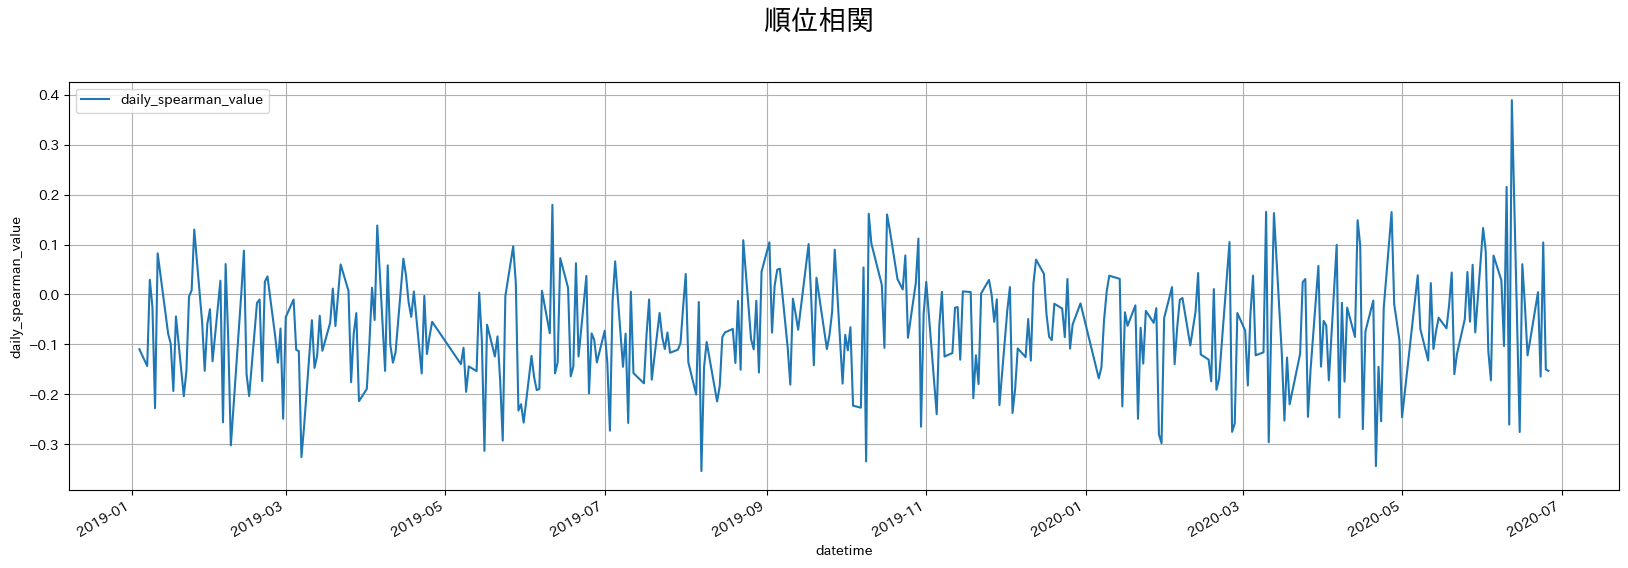
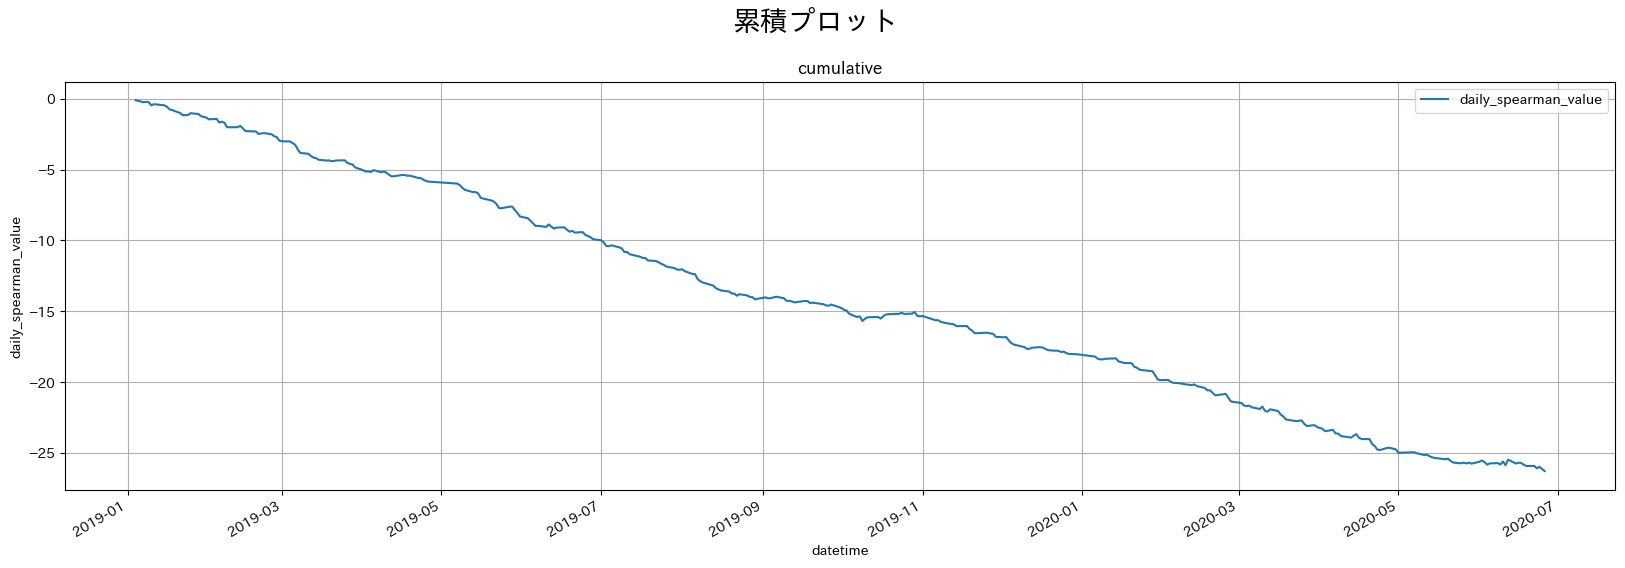

In [ ]:
# 「空売の出来高」に対して当日の始値から終値の価格変化率の順位相関を2019/2020年の時系列的にプロット

# 空売の出来高
# => 以下の2つの列の合計値
# ===============================
# vo_1_0_5
# 空売り（信用新規売りを除く）のうち、価格規制の適用除外ではない注文の約定数量
# vo_1_0_7
# 空売り（信用新規売りを除く）のうち、価格規制の適用除外である注文の約定数量
# ===============================
work_df.loc[:, "short_volume"] = work_df[["vo_1_0_5", "vo_1_0_7"]].sum(axis=1).fillna(0)

# 順位相関の保存用
daily_spearman_value = []
for business_day in business_days:
    spearman_df = work_df.loc[business_day, ["intra_return", "short_volume"]].corr(method="spearman")
    daily_spearman_value.append(spearman_df.iloc[0, 1])

# 可視化用にデータフレームを作成
daily_spearmans_df = pd.DataFrame({
    "daily_spearman_value": daily_spearman_value,
}, index=business_days)

# 順位相関のプロット

# プロット用に準備
plot_cols = daily_spearmans_df.columns
feature_df = daily_spearmans_df

# プロット
num_feature = len(plot_cols)
fig, axes = plt.subplots(len(plot_cols), 1, figsize=(20, len(plot_cols) * 6))
axes = [axes]

plt.suptitle("順位相関", size=20, y=1.0)
for i, feature_name in enumerate(plot_cols):
    feature_df[[feature_name]].plot(ax=axes[i])
    axes[i].set_ylabel(feature_name)
    axes[i].set_xlabel("datetime")
    axes[i].grid(True)
    axes[i].legend()
plt.show()
    
# 累積プロット用に準備
plot_cols = daily_spearmans_df.columns
feature_df = daily_spearmans_df[plot_cols].cumsum()

# 累積プロット
num_feature = len(plot_cols)
fig, axes = plt.subplots(len(plot_cols), 1, figsize=(20, len(plot_cols) * 6))
axes = [axes]

plt.suptitle("累積プロット", size=20, y=1.0)
axes[0].set_title("cumulative")
for i, feature_name in enumerate(plot_cols):
    feature_df[[feature_name]].plot(ax=axes[i])
    axes[i].set_ylabel(feature_name)
    axes[i].set_xlabel("datetime")
    axes[i].grid(True)
    axes[i].legend()
plt.show()

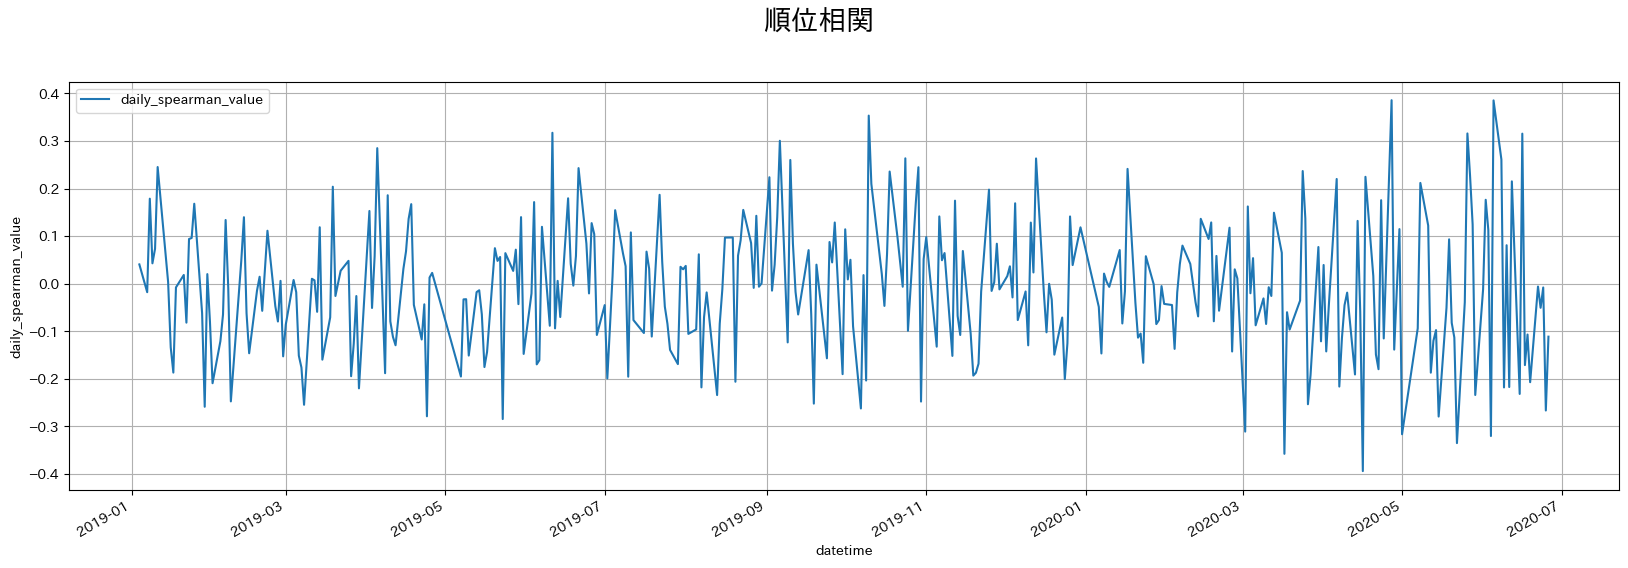
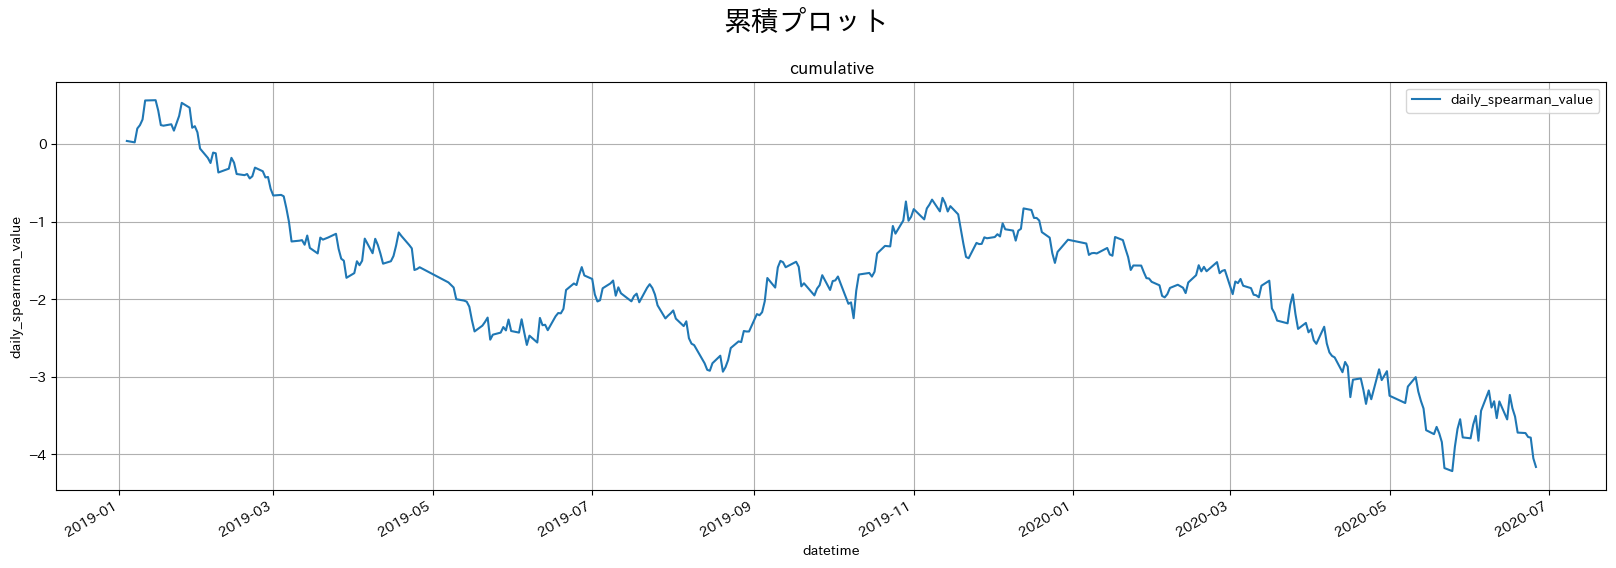

In [ ]:
# 時価総額固有の特徴解析

# 時価総額上位33%の現物買いの約定代金
# 時価総額下位33%の現物買いの約定代金
# => 2020-06-26 時点の時価総額データを作成する
#   => price_df の終値 ("EndOfDayQuote ExchangeOfficialClose") と list_df の 発行済株式数 ("IssuedShareEquityQuote IssuedShare") をかければ良い

# 発行済株式数の存在しない銘柄を除外します。
work_df = work_df.loc[work_df["IssuedShareEquityQuote IssuedShare"].notna()]
# 2020年6月26日のレコードに絞り込み
marketcap_df = work_df.loc[work_df.index == "2020-06-26"].copy()
# 時価総額を計算
marketcap_df.loc[:, "marketcap"] = marketcap_df.loc[:, ["EndOfDayQuote ExchangeOfficialClose", "IssuedShareEquityQuote IssuedShare"]].sum(axis=1)
# 時価総額の大きい順に並べ替える
marketcap_df = marketcap_df.sort_values("marketcap", ascending=False)
# 時価総額を計算した銘柄数を取得
num_of_marketcap = marketcap_df.shape[0]

# 時価総額上位/下位33%地点を取得
top_N_position = int(num_of_marketcap / 3)
bottom_N_position = num_of_marketcap - top_N_position

# 時価総額上位/下位33%の銘柄群を取得
top_N_df = marketcap_df.iloc[:top_N_position]
bottom_N_df = marketcap_df.iloc[bottom_N_position:]

# 対象ユニバースに絞り込む
universe_df = work_df.loc[work_df["Local Code"].isin(marketcap_df["Local Code"]), ["Local Code", "va_3_0_0"]]

# 現物買いの約定代金
# => va_3_0_0
universe_df.loc[:, "universe_spot_buy"] = universe_df["va_3_0_0"]
universe_df.loc[universe_df["Local Code"].isin(top_N_df["Local Code"]), "top_N_spot_buy"] = universe_df.loc[universe_df["Local Code"].isin(top_N_df["Local Code"]), "universe_spot_buy"]
universe_df.loc[universe_df["Local Code"].isin(bottom_N_df["Local Code"]), "bottom_N_spot_buy"] = universe_df.loc[universe_df["Local Code"].isin(bottom_N_df["Local Code"]), "universe_spot_buy"]

# 日次で集計
ret_df = universe_df.groupby(universe_df.index)[["universe_spot_buy", "top_N_spot_buy", "bottom_N_spot_buy"]].mean()

# plot
ret_df[["universe_spot_buy", "top_N_spot_buy", "bottom_N_spot_buy"]].plot(figsize=(20, 8))
plt.show()

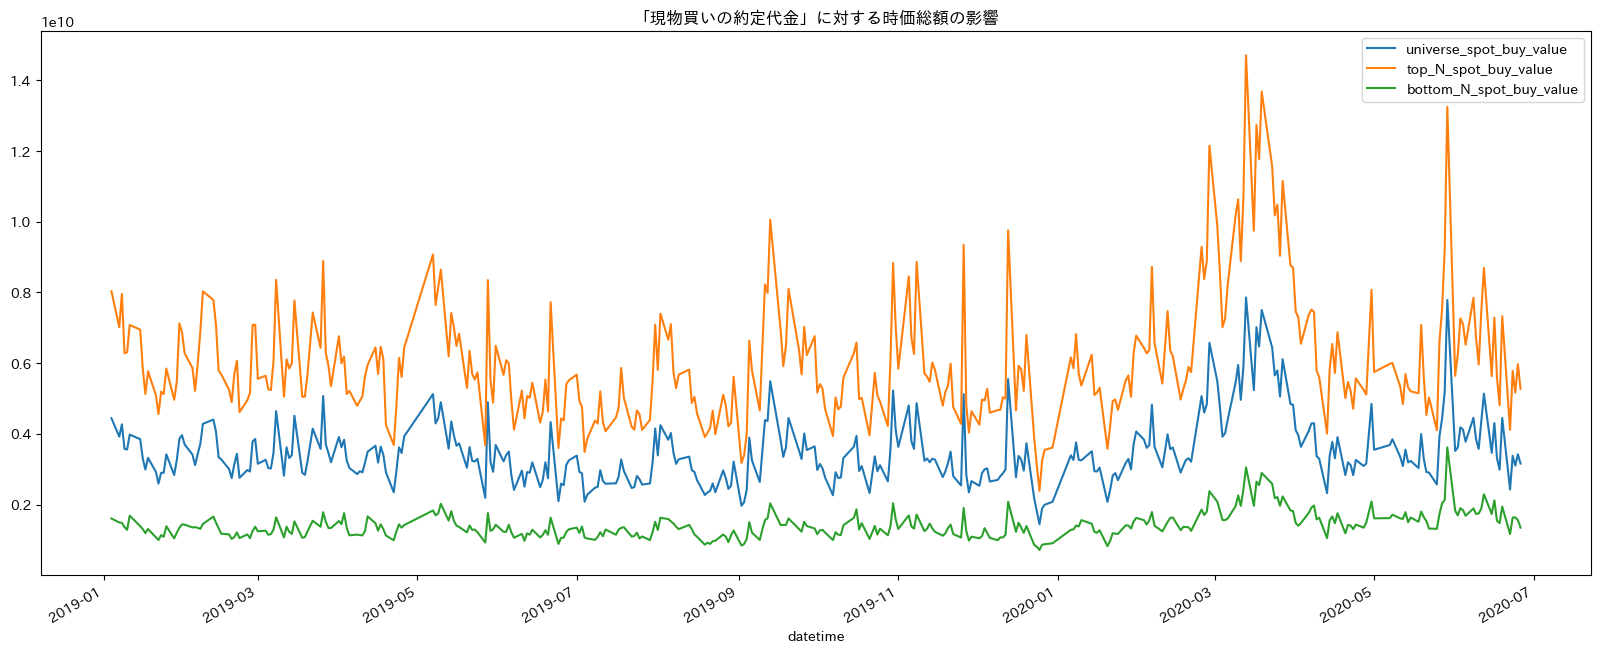

In [ ]:
# ほかにも時価総額が影響を与えていそうな部分を仮設し、検証

In [ ]:
# 対象ユニバースに絞り込む
universe_df = work_df.loc[work_df["Local Code"].isin(marketcap_df["Local Code"]), ["Local Code", "EndOfDayQuote Volume", "vo_1_0_5"]]
# 時価総額上位/下位33%の出来高を作成
universe_df.loc[universe_df["Local Code"].isin(top_N_df["Local Code"]), "top_N_volume"] = universe_df.loc[universe_df["Local Code"].isin(top_N_df["Local Code"]), "EndOfDayQuote Volume"]
universe_df.loc[universe_df["Local Code"].isin(bottom_N_df["Local Code"]), "bottom_N_volume"] = universe_df.loc[universe_df["Local Code"].isin(bottom_N_df["Local Code"]), "EndOfDayQuote Volume"]
# 時価総額上位/下位33%の空売り（信用新規売りを除く）のうち、価格規制の適用除外ではない注文の約定数を作成
universe_df.loc[universe_df["Local Code"].isin(top_N_df["Local Code"]), "top_N_vo_1_0_5"] = universe_df.loc[universe_df["Local Code"].isin(top_N_df["Local Code"]), "vo_1_0_5"]
universe_df.loc[universe_df["Local Code"].isin(bottom_N_df["Local Code"]), "bottom_N_vo_1_0_5"] = universe_df.loc[universe_df["Local Code"].isin(bottom_N_df["Local Code"]), "vo_1_0_5"]
# # 空売り（信用新規売りを除く）のうち、価格規制の適用除外ではない注文の約定数の当日の出来高に対する割合
universe_df.loc[:, "universe_short_ratio"] = universe_df["vo_1_0_5"] / universe_df["EndOfDayQuote Volume"]
universe_df.loc[universe_df["Local Code"].isin(top_N_df["Local Code"]), "top_N_short_ratio"] = universe_df.loc[universe_df["Local Code"].isin(top_N_df["Local Code"]), "universe_short_ratio"]
universe_df.loc[universe_df["Local Code"].isin(bottom_N_df["Local Code"]), "bottom_N_short_ratio"] = universe_df.loc[universe_df["Local Code"].isin(bottom_N_df["Local Code"]), "universe_short_ratio"]

# 日次で集計
ret_df = universe_df.groupby(universe_df.index)[["universe_short_ratio", "top_N_short_ratio", "bottom_N_short_ratio"]].mean()

# plot
ret_df[["universe_short_ratio", "top_N_short_ratio", "bottom_N_short_ratio"]].plot(figsize=(20, 8))
plt.show()

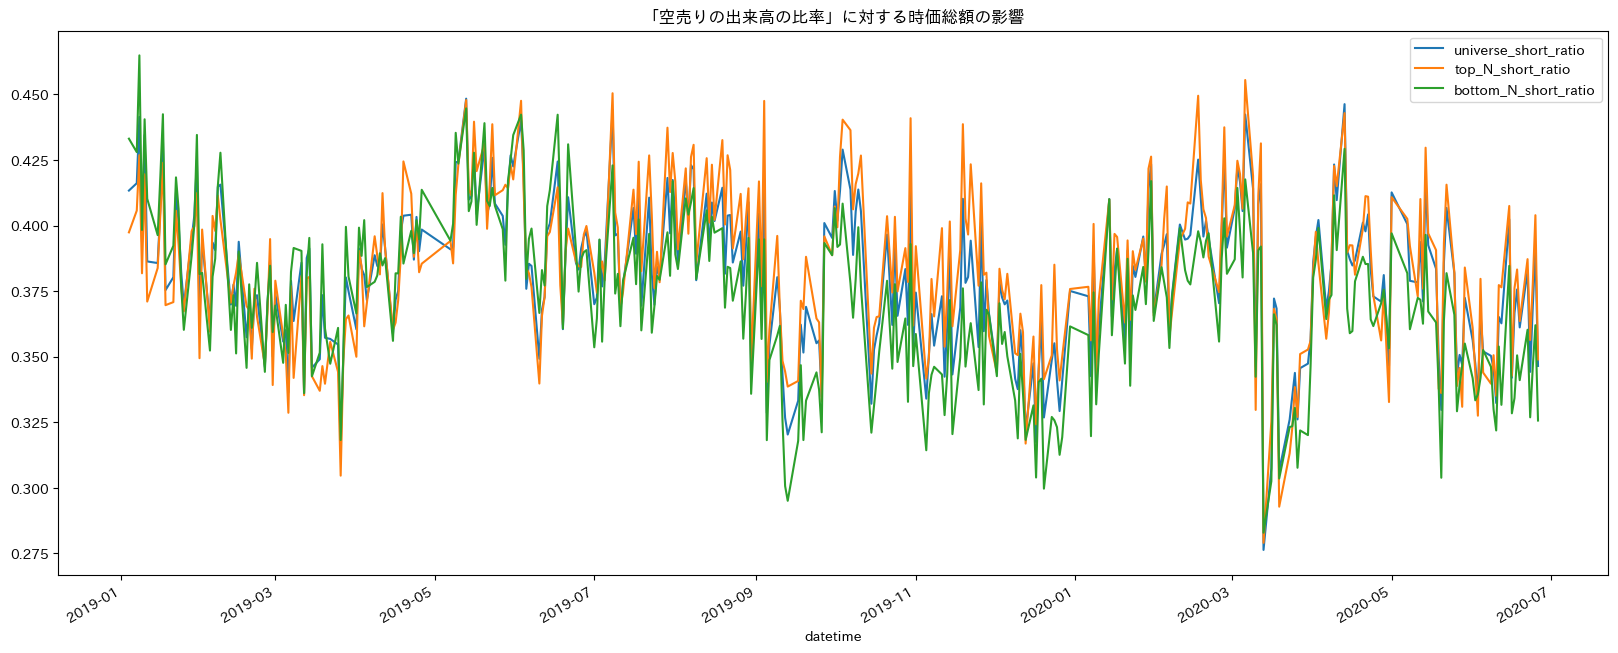

# 目的関数の設計と評価関数

In [ ]:
# なぜか始値が 0 になっているものがあり、これがあると評価ができないので除外してから評価する
work_df = work_df[work_df["EndOfDayQuote Open"] != 0]

In [ ]:
# 評価のパターンCおよびDを実装

# 評価のパターンC
# エントリー価格として「次の営業日の終値」
# エグジット価格として「３-２１営業日後の終値」
def _return_C(df):
    df = df.sort_values("datetime")
    return df["EndOfDayQuote ExchangeOfficialClose"].pct_change().shift(-10)
work_df.loc[:, "return_C"] = work_df.groupby("Local Code").apply(_return_C).values

# 評価のパターンD
# エントリー価格として「２営業日の終値」
# エグジット価格として「１ヶ月以上先の長い期間の終値」
def _return_D(df):
    df = df.sort_values("datetime")
    return df["EndOfDayQuote ExchangeOfficialClose"].pct_change().shift(-30)
work_df.loc[:, "return_D"] = work_df.groupby("Local Code").apply(_return_D).values

In [ ]:
# 「次の営業日の始値」、エグジット価格として「次の営業日後の終値」のケース (評価のパターンA)
def _return_A(df):
    df = df.sort_values("datetime")
    a = df[["EndOfDayQuote Open", "EndOfDayQuote ExchangeOfficialClose"]].pct_change(axis=1)["EndOfDayQuote ExchangeOfficialClose"].shift(-1)
    return a
work_df.loc[:, "return_A"] = work_df.groupby("Local Code").apply(_return_A).values

# エントリー価格として「次の日の終値」、エグジット価格として「2営業日後の終値」 とした場合のリターンを算出 (評価のパターンB)
def _return_B(df):
    df = df.sort_values("datetime")
    return df["EndOfDayQuote ExchangeOfficialClose"].pct_change().shift(-2)
work_df.loc[:, "return_B"] = work_df.groupby("Local Code").apply(_return_B).values

In [ ]:
# 空売りデータによる実践1

In [ ]:
# 空売の出来高
# => vo_1_0_5 + vo_1_0_7
work_df.loc[:, "short_volume"] = work_df[["vo_1_0_5", "vo_1_0_7"]].sum(axis=1).fillna(0)

# 空売りの約定代金
# => va_1_0_5 + va_1_0_7
work_df.loc[:, "short_value"] = work_df[["va_1_0_5", "va_1_0_7"]].sum(axis=1).fillna(0)

# 空売りの出来高を全体の出来高で正規化して、空売りの出来高の変化量を計算
work_df.loc[:, "normalized_short_volume"] = work_df["short_volume"] /  work_df["EndOfDayQuote Volume"]

# 空売りの約定代金を全体の約定代金で正規化して、空売りの約定代金の変化量を計算
# => 全体の約定代金は "EndOfDayQuote ExchangeOfficialClose" * "EndOfDayQuote Volume" で代用します。
work_df.loc[:, "normalized_short_value"] = work_df["short_value"] / (work_df["EndOfDayQuote ExchangeOfficialClose"] * work_df["EndOfDayQuote Volume"])

# 時価総額上位33%の当日の出来高に占める割合
# 時価総額下位33%の当日の出来高に占める割合
# => 2020-06-26 時点の時価総額データを作成する
#   => price_df の終値 ("EndOfDayQuote ExchangeOfficialClose") と list_df の 発行済株式数 ("IssuedShareEquityQuote IssuedShare") をかければ良い

# 発行済株式数データの存在しない銘柄を除外します。
work_df = work_df.loc[work_df["IssuedShareEquityQuote IssuedShare"].notna()]
# 2020年6月26日のレコードに絞り込み
marketcap_df = work_df.loc[work_df.index == "2020-06-26"].copy()
# 時価総額を計算
marketcap_df.loc[:, "marketcap"] = marketcap_df.loc[:, ["EndOfDayQuote ExchangeOfficialClose", "IssuedShareEquityQuote IssuedShare"]].prod(axis=1)
# 時価総額を結合します
work_df = pd.merge(work_df.reset_index(), marketcap_df[["Local Code", "marketcap"]], how="inner", on="Local Code").set_index("datetime")
# 計算用に並び順を調整します。
work_df = work_df.sort_values(["Local Code", "datetime"])

In [ ]:
# short_value と return_B の日次の順位相関の時系列を計算する
df_short_value = work_df.groupby("datetime")[["short_value", "return_B"]].corr(method="spearman")

# normalized_short_value と return_B の日次の順位相関の時系列を計算する
df_normalized_short_value = work_df.groupby("datetime")[["normalized_short_value", "return_B"]].corr(method="spearman")

# short_volume と return_B の日次の順位相関の時系列を計算する
df_short_volume = work_df.groupby("datetime")[["short_volume", "return_B"]].corr(method="spearman")

# normalized_short_volume と return_B の日次の順位相関の時系列を計算する
df_normalized_short_volume = work_df.groupby("datetime")[["normalized_short_volume", "return_B"]].corr(method="spearman")

ret_df = pd.DataFrame({
    "short_value": df_short_value.xs("return_B", level=1)["short_value"],
    "normalized_short_value": df_normalized_short_value.xs("return_B", level=1)["normalized_short_value"],
    "short_volume": df_short_volume.xs("return_B", level=1)["short_volume"],
    "normalized_short_volume": df_normalized_short_volume.xs("return_B", level=1)["normalized_short_volume"],
})

# 累積にしてプロット
ret_df.cumsum().plot(figsize=(20, 8), legend="t")
plt.show()

# 順位相関の分布情報を出力
display(ret_df.describe(percentiles=[0.05, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95]))

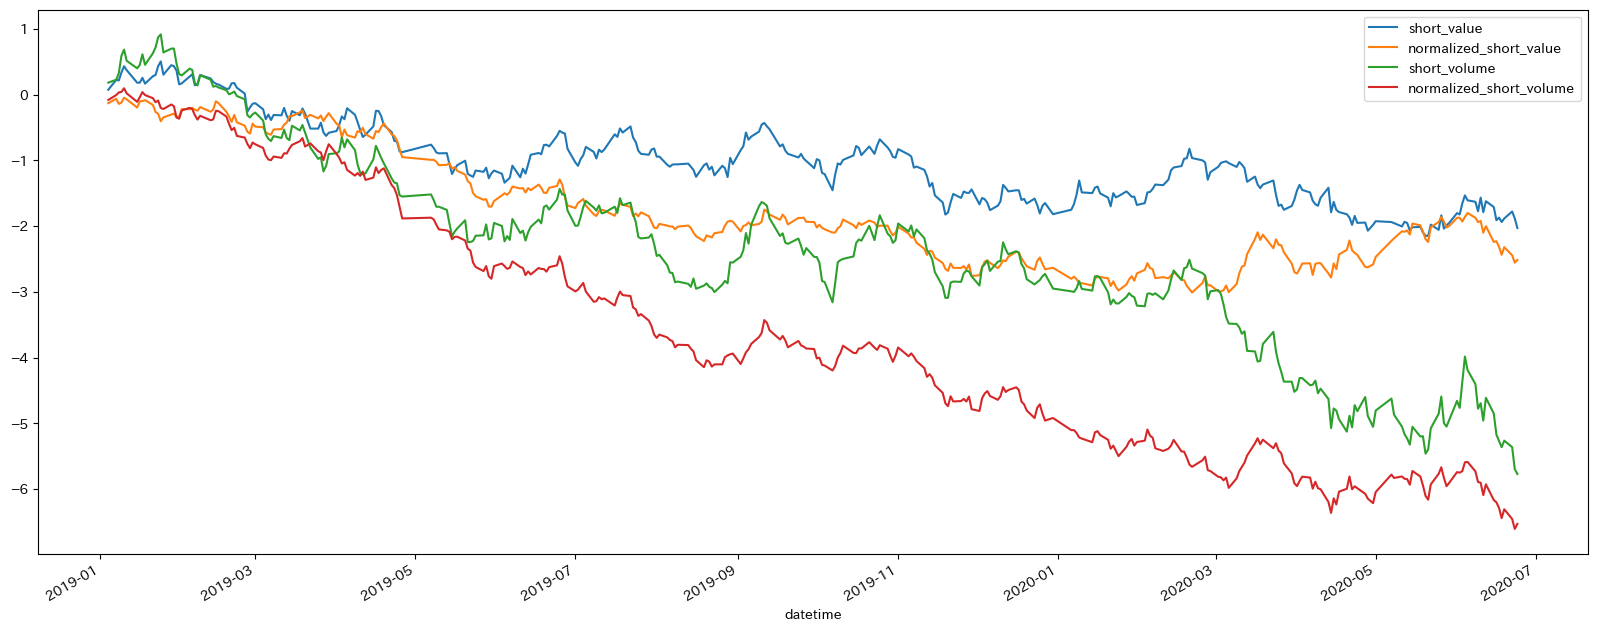
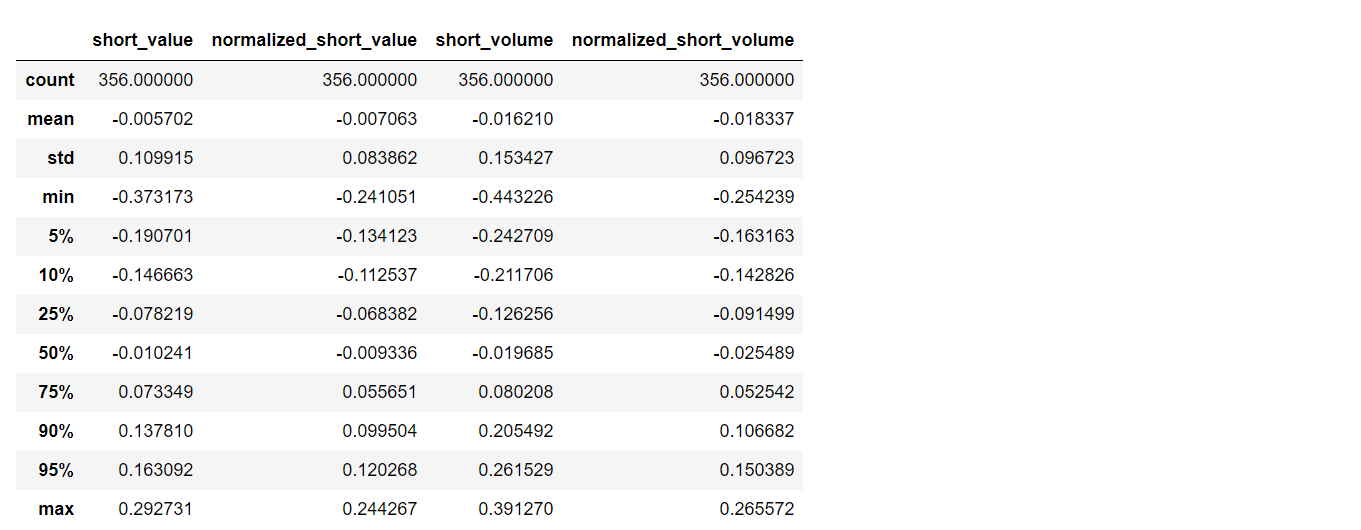

In [ ]:
# 空売りデータによる実践2

In [ ]:
# 符号を逆転させています。
work_df.loc[:, "normalized_short_value"] = work_df.loc[:, "normalized_short_value"] * -1
work_df.loc[:, "normalized_short_volume"] = work_df.loc[:, "normalized_short_volume"] * -1

# スコアをベースにスプレッドリターンを算出
def _calc_spared_returns(df):
    df = df.sort_values(["normalized_short_volume", "marketcap"])
    bins = 10
    df.loc[:, "bins"] = pd.qcut(df["normalized_short_volume"].rank(method="first"), bins, labels=False)
    
    returns = {}
    for i in range(10):
        returns[f"return_A_bin_{i}"] = df.loc[df["bins"].isin([i]), "return_A"].sum()
        returns[f"return_B_bin_{i}"] = df.loc[df["bins"].isin([i]), "return_B"].sum()
    returns["return_B_bin_01"] = df.loc[df["bins"].isin([0, 1]), "return_B"].sum()
    returns["return_B_bin_89"] = df.loc[df["bins"].isin([8, 9]), "return_B"].sum()
    returns["return_B_spread_return_20p"] = df.loc[df["bins"].isin([8, 9]), "return_B"].sum() - df.loc[df["bins"].isin([0, 1]), "return_B"].sum()
    returns["return_B_spread_return_10p"] = df.loc[df["bins"].isin([9]), "return_B"].sum() - df.loc[df["bins"].isin([0]), "return_B"].sum()
    returns["return_A_bin_01"] = df.loc[df["bins"].isin([0, 1]), "return_A"].sum()
    returns["return_A_bin_89"] = df.loc[df["bins"].isin([8, 9]), "return_A"].sum()
    returns["return_A_spread_return_20p"] = df.loc[df["bins"].isin([8, 9]), "return_A"].sum() - df.loc[df["bins"].isin([0, 1]), "return_A"].sum()
    returns["return_A_spread_return_10p"] = df.loc[df["bins"].isin([9]), "return_A"].sum() - df.loc[df["bins"].isin([1]), "return_A"].sum()    
    return pd.DataFrame([returns], columns=returns.keys())

df_spread_returns = work_df.groupby("datetime").apply(_calc_spared_returns)

df_spread_returns[["return_A_spread_return_20p", "return_A_bin_89", "return_A_bin_01"]].cumsum().plot(figsize=(20, 8), grid=True)
plt.title("パターンA")
plt.show()

df_spread_returns[["return_B_spread_return_20p", "return_B_bin_89", "return_B_bin_01"]].cumsum().plot(figsize=(20, 8), grid=True)
plt.title("パターンB")
plt.show()

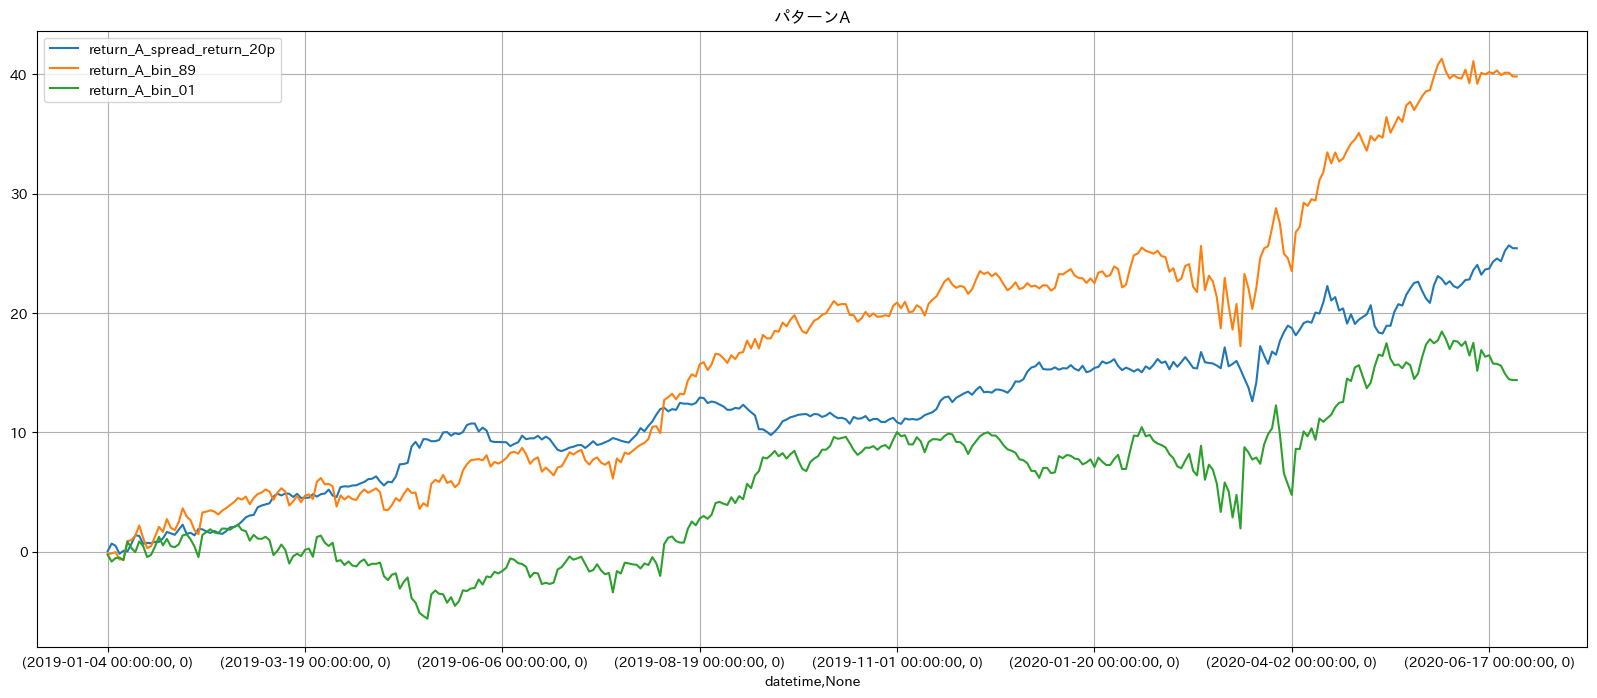
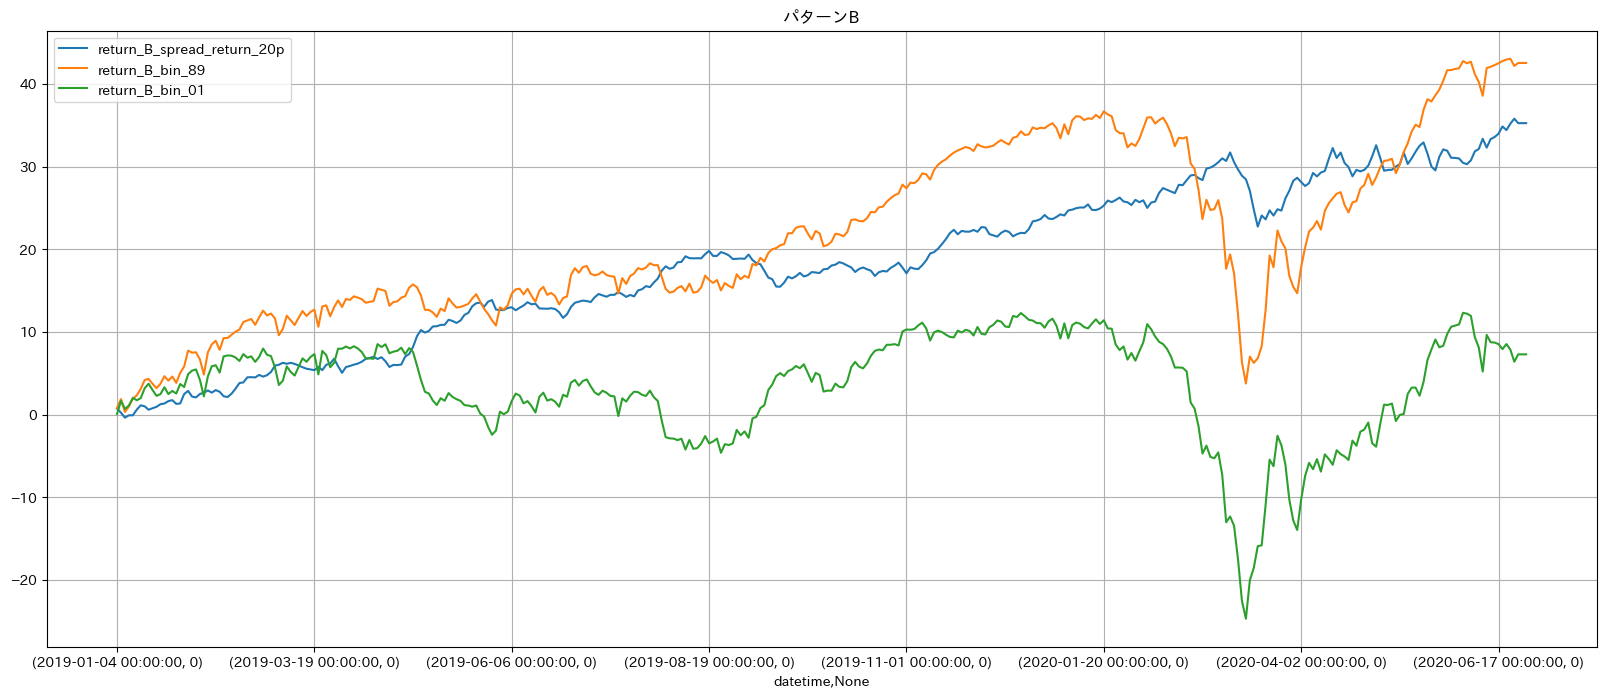

In [ ]:
# 重要なトレードメトリクス

In [ ]:
# 評価パターンA
ret = {}

# 平均リターン
# トレード1回あたりの平均の利益率を示します。合計損益を総トレード数で割ることで算出します。
avg_return = df_spread_returns["return_A_spread_return_10p"].sum() / df_spread_returns["return_A_spread_return_10p"].shape[0]
ret["avg_return"] = avg_return

# 勝率
# トレードがどの程度勝つかを示す指標です。勝ちトレード数 (利益が0を超えるトレード数) を総トレード数で割ることで算出します。
win_ratio = df_spread_returns["return_A_spread_return_10p"].loc[df_spread_returns["return_A_spread_return_10p"] > 0].shape[0] / df_spread_returns["return_A_spread_return_10p"].shape[0]
ret["win_ratio"] = win_ratio

# 最大ドローダウン
# 累積リターンの最大地点からの下落率のことです。取引戦略のリスクを知る上で重要な指標です。
max_drawdown = (df_spread_returns["return_A_spread_return_10p"].cumsum().cummax() - df_spread_returns["return_A_spread_return_10p"].cumsum()).max()
ret["max_drawdown"] = max_drawdown

# シャープレシオ
# リスクに応じた利益を得られているかを示します。リターンから安全資産利回りを引いてそのリターンの標準偏差で割ることで算出します。
# 週・月・年などの計算の単位で大きく結果が変わることに注意が必要です。
# 日本株のアルゴリズムトレードの評価では、金利水準などを考慮し、安定資産利回りは0%で計算することが多いです。
sharpe_ratio = df_spread_returns["return_A_spread_return_10p"].mean() / df_spread_returns["return_A_spread_return_10p"].std(ddof=1)
ret["sharpe_ratio"] = sharpe_ratio

# ベータ
# ベンチマークとなる指数や取引対象のユニバースに対する合計収益の連動率です。たとえば、ベンチマークとなる指数が10%上昇したときに11%上昇したらベータは1.1となります。
# ref. https://qiita.com/ku_a_i/items/4214f85fcae4d147f009
df_univ_return_A = work_df["return_A"].groupby("datetime").sum()
df_univ_return_A.name = "univ_return_A"
df_join = df_spread_returns["return_A_spread_return_10p"].to_frame().join(df_univ_return_A)
cov_matrix = df_join[["univ_return_A", "return_A_spread_return_10p"]].cov()
# ベータ値 ＝ 共分散(マーケット・個別)／分散(マーケット)
beta = cov_matrix.iloc[0,1] / cov_matrix.iloc[0,0]
ret["beta"] = beta

display(pd.DataFrame([ret]).T)

# 評価パターンB
ret = {}

# 平均リターン
# トレード1回あたりの平均の利益率を示します。合計損益を総トレード数で割ることで算出します。
avg_return = df_spread_returns["return_B_spread_return_10p"].sum() / df_spread_returns["return_B_spread_return_10p"].shape[0]
ret["avg_return"] = avg_return

# 勝率
# トレードがどの程度勝つかを示す指標です。勝ちトレード数 (利益が0を超えるトレード数) を総トレード数で割ることで算出します。
win_ratio = df_spread_returns["return_B_spread_return_10p"].loc[df_spread_returns["return_B_spread_return_10p"] > 0].shape[0] / df_spread_returns["return_B_spread_return_10p"].shape[0]
ret["win_ratio"] = win_ratio

# 最大ドローダウン
# 累積リターンの最大地点からの下落率のことです。取引戦略のリスクを知る上で重要な指標です。
max_drawdown = (df_spread_returns["return_B_spread_return_10p"].cumsum().cummax() - df_spread_returns["return_B_spread_return_10p"].cumsum()).max()
ret["max_drawdown"] = max_drawdown

# シャープレシオ
# リスクに応じた利益を得られているかを示します。リターンから安全資産利回りを引いてそのリターンの標準偏差で割ることで算出します。
# 週・月・年などの計算の単位で大きく結果が変わることに注意が必要です。
# 日本株のアルゴリズムトレードの評価では、金利水準などを考慮し、安定資産利回りは0%で計算することが多いです。
sharpe_ratio = df_spread_returns["return_B_spread_return_10p"].mean() / df_spread_returns["return_B_spread_return_10p"].std(ddof=1)
ret["sharpe_ratio"] = sharpe_ratio

# ベータ
# ベンチマークとなる指数や取引対象のユニバースに対する合計収益の連動率です。たとえば、ベンチマークとなる指数が10%上昇したときに11%上昇したらベータは1.1となります。
# ref. https://qiita.com/ku_a_i/items/4214f85fcae4d147f009
df_univ_return_B = work_df["return_B"].groupby("datetime").sum()
df_univ_return_B.name = "univ_return_B"
df_join = df_spread_returns["return_B_spread_return_10p"].to_frame().join(df_univ_return_B)
cov_matrix = df_join[["univ_return_B", "return_B_spread_return_10p"]].cov()
# ベータ値 ＝ 共分散(マーケット・個別)／分散(マーケット)
beta = cov_matrix.iloc[0,1] / cov_matrix.iloc[0,0]
ret["beta"] = beta

display(pd.DataFrame([ret]).T)

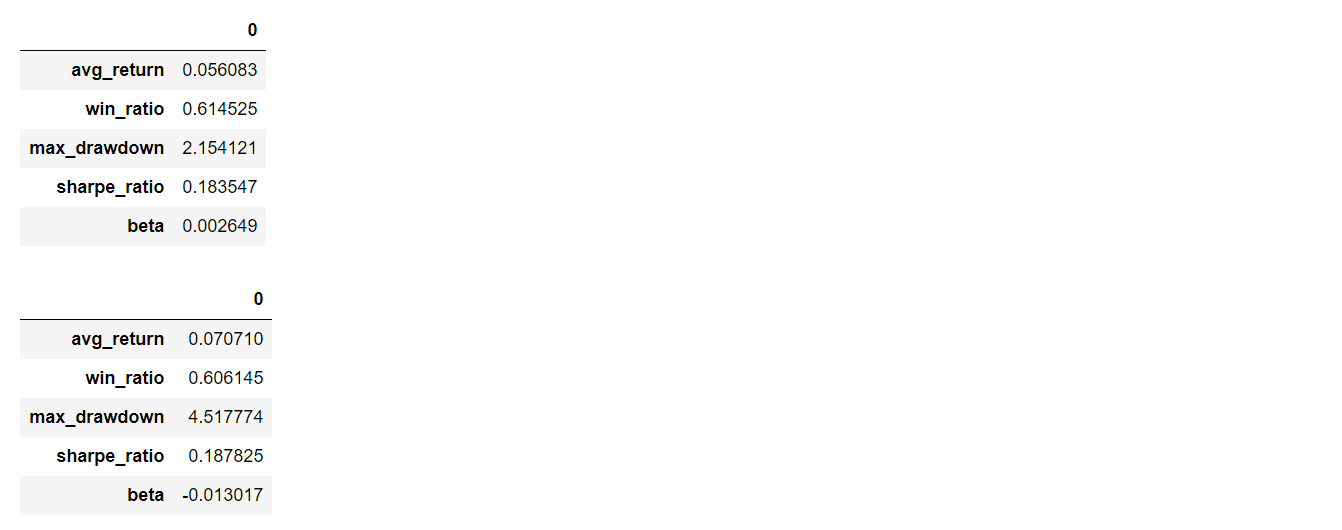

# 特徴量の設計

In [ ]:
# 信用買いの特徴量
# 信用新規買いの出来高
# => vo_3_2_0

# 信用新規買いの出来高を全体の出来高で正規化して、空売りの出来高の変化量を計算
work_df.loc[:, "normalized_margin_buy_volume"] = work_df["vo_3_2_0"] /  work_df["EndOfDayQuote Volume"]

# normalized_margin_buy_value と return_B の日次の順位相関の時系列を計算する
df_normalized_margin_buy_value = work_df.groupby("datetime")[["normalized_margin_buy_volume", "return_B"]].corr(method="spearman")

ret_df = pd.DataFrame({
    "normalized_margin_buy_volume": df_normalized_margin_buy_value.xs("return_B", level=1)["normalized_margin_buy_volume"]
})

# 累積にしてプロット
ret_df.cumsum().plot(figsize=(20, 8), legend="t")
plt.title("信用新規買いの出来高の比率とreturn_Bの順位相関の累積")
plt.show()

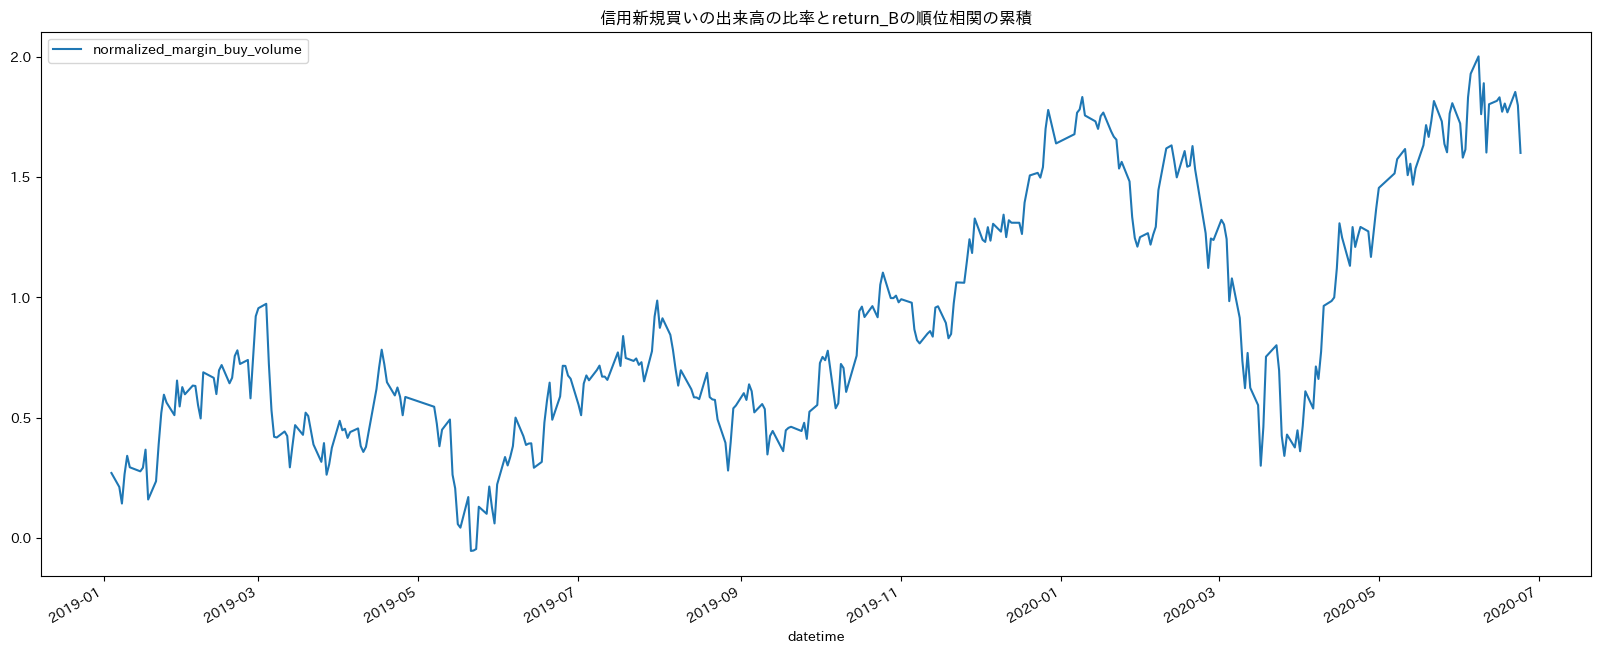

In [ ]:
# 移動平均を利用した特徴量の評価

In [ ]:
# 空売り比率にたいして移動平均を適用
def _ma_normalized_short_volume(df, rolling=5):
    df = df.sort_values("datetime")
    a = df["normalized_short_volume"].rolling(rolling).mean().fillna(0)
    return a
for i in [5, 10, 20]:
    work_df.loc[:, f"normalized_short_volume_ma{i}"] = work_df.groupby("Local Code").apply(functools.partial(_ma_normalized_short_volume, rolling=i)).values

# スコアをベースにスプレッドリターンを算出
def _calc_spared_returns(df, score_column="normalized_short_value"):
    df = df.sort_values([score_column, "marketcap"])
    bins = 10
    df.loc[:, "bins"] = pd.qcut(df[score_column].rank(method="first"), bins, labels=False)
    
    returns = {}
    for i in range(10):
        returns[f"return_A_bin_{i}"] = df.loc[df["bins"].isin([i]), "return_A"].sum()
        returns[f"return_B_bin_{i}"] = df.loc[df["bins"].isin([i]), "return_B"].sum()
    returns["return_B_bin_01"] = df.loc[df["bins"].isin([0, 1]), "return_B"].sum()
    returns["return_B_bin_89"] = df.loc[df["bins"].isin([8, 9]), "return_B"].sum()
    returns["return_B_spread_return_20p"] = df.loc[df["bins"].isin([8, 9]), "return_B"].sum() - df.loc[df["bins"].isin([0, 1]), "return_B"].sum()
    returns["return_B_spread_return_10p"] = df.loc[df["bins"].isin([9]), "return_B"].sum() - df.loc[df["bins"].isin([0]), "return_B"].sum()
    returns["return_A_bin_01"] = df.loc[df["bins"].isin([0, 1]), "return_A"].sum()
    returns["return_A_bin_89"] = df.loc[df["bins"].isin([8, 9]), "return_A"].sum()
    returns["return_A_spread_return_20p"] = df.loc[df["bins"].isin([8, 9]), "return_A"].sum() - df.loc[df["bins"].isin([0, 1]), "return_A"].sum()
    returns["return_A_spread_return_10p"] = df.loc[df["bins"].isin([9]), "return_A"].sum() - df.loc[df["bins"].isin([1]), "return_A"].sum()    
    return pd.DataFrame([returns], columns=returns.keys())

df_spread_returns = work_df.groupby("datetime").apply(functools.partial(_calc_spared_returns, score_column="normalized_short_volume"))
ax = df_spread_returns[["return_B_spread_return_10p"]].rename(columns={"return_B_spread_return_10p": "raw"}).cumsum().plot(figsize=(20, 8))
df_spread_returns = work_df.groupby("datetime").apply(functools.partial(_calc_spared_returns, score_column="normalized_short_volume_ma5"))
df_spread_returns[["return_B_spread_return_10p"]].rename(columns={"return_B_spread_return_10p": "ma5"}).cumsum().plot(figsize=(20, 8), ax=ax)
df_spread_returns = work_df.groupby("datetime").apply(functools.partial(_calc_spared_returns, score_column="normalized_short_volume_ma10"))
df_spread_returns[["return_B_spread_return_10p"]].rename(columns={"return_B_spread_return_10p": "ma10"}).cumsum().plot(figsize=(20, 8), ax=ax)
df_spread_returns = work_df.groupby("datetime").apply(functools.partial(_calc_spared_returns, score_column="normalized_short_volume_ma20"))
df_spread_returns[["return_B_spread_return_10p"]].rename(columns={"return_B_spread_return_10p": "ma20"}).cumsum().plot(figsize=(20, 8), ax=ax)
plt.title("移動平均を利用した特徴量の評価")
plt.show()

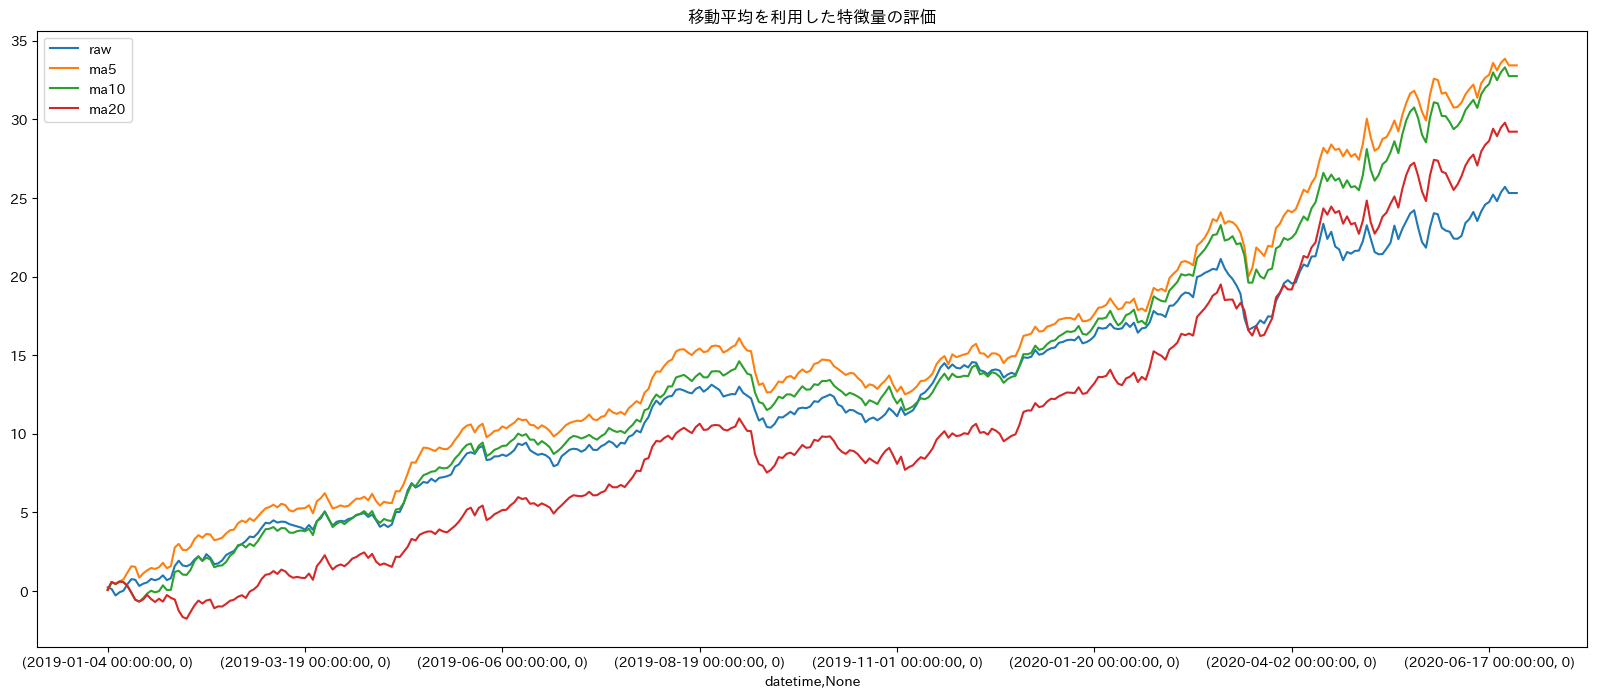

In [ ]:
# データの分割

In [ ]:
# 特徴量の作成
# 5、20営業日のリターン
# 5、20営業日のヒストリカル・ボラティリティ
def generate_feature(df):
    df.loc[:, "return_5d"] = np.log(df["EndOfDayQuote ExchangeOfficialClose"]).diff(5)
    df.loc[:, "return_20d"] = np.log(df["EndOfDayQuote ExchangeOfficialClose"]).diff(20)
    df.loc[:, "volatility_5d"] = np.log(df["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(5).std()
    df.loc[:, "volatility_20d"] = np.log(df["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    return df

work_df = work_df.groupby("Local Code").apply(generate_feature)

In [ ]:
# データの分割は以下のようになります
TRAIN_START_DT = "2019-01-01"
TRAIN_END_DT = "2019-12-31"
VAL_START_DT = "2020-01-10"
VAL_END_DT = "2020-03-31"
TEST_START_DT = "2020-04-01"
TEST_END_DT = "2020-06-30"

train_df = work_df.loc[TRAIN_START_DT:TRAIN_END_DT]
val_df = work_df.loc[VAL_START_DT:VAL_END_DT]
test_df = work_df.loc[TEST_START_DT:TEST_END_DT]

# 一部カラムには nan が含まれているため、0でフィルします
train_df = train_df.fillna(0)
val_df = val_df.fillna(0)
test_df = test_df.fillna(0)

# 決定木モデルの構築

In [ ]:
rf_params = {
    "n_estimators": 100,
    "criterion": "mse",
    "max_depth": 6,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": 1.0,
    'n_jobs': None,
    "verbose": 1,
    'random_state': 0,
}

models = {
    "rf": RandomForestRegressor,
}
feat_cols = [
    "return_5d",
    "return_20d",
    "volatility_5d",
    "volatility_20d",
    "normalized_short_volume",
    #追加
    "normalized_short_volume_ma5",
    "normalized_short_volume_ma10",
    "normalized_short_volume_ma20",
    "normalized_margin_buy_value"
]

label = "return_B"
feat_name = "feat_set1"

In [ ]:
train_X = {}
train_y = {}
test_X = {}
test_y = {}

train_X[label] = train_df[feat_cols + ["Local Code"]].rename(columns={"Local Code": "code"})
train_y[label] = train_df[label]
test_X[label] = test_df[feat_cols + ["Local Code"]].rename(columns={"Local Code": "code"})
test_y[label] = test_df[label]

trained_models = {
    "rf": {
        feat_name: {
            label: None
        }
    },
}
result = {
    label: {}
}

model_name = "rf"
model_params = rf_params

In [ ]:
# モデル取得
pred_model = models[model_name](**model_params)
# 学習
pred_model.fit(train_X[label][feat_cols].values, train_y[label])
# 学習済みモデル保存
trained_models[model_name][feat_name][label] = pred_model
# 結果データ作成
result[label] = test_X[label][["code"]].copy()
result[label]["datetime"] = test_X[label][feat_cols].index

In [ ]:
# 予測
result[label]["predict"] = pred_model.predict(test_X[label][feat_cols])
result[label]["predict_dir"] = np.sign(result[label]["predict"])

In [ ]:
# 実際の結果
result[label]["actual"] = test_y[label].values
result[label]["actual_dir"] = np.sign(result[label]["actual"])
result[label].dropna(inplace=True)

In [ ]:
all_results = {}
all_results[model_name] = {}
all_results[model_name][feat_name] = result.copy()

results = []
for model in tqdm(all_results.keys()):
    for col in tqdm(all_results[model]):
        display(model, col)
        tmp = pd.concat(all_results[model][col])
        tmp["model"] = model
        tmp["feature"] = col
        results.append(tmp)
results = pd.concat(results)
results["label"] = [x[0] for x in results.index]
results["id"] = results["code"].astype(str)+results["datetime"].dt.strftime('%Y%m%d')
display(results.head(5))

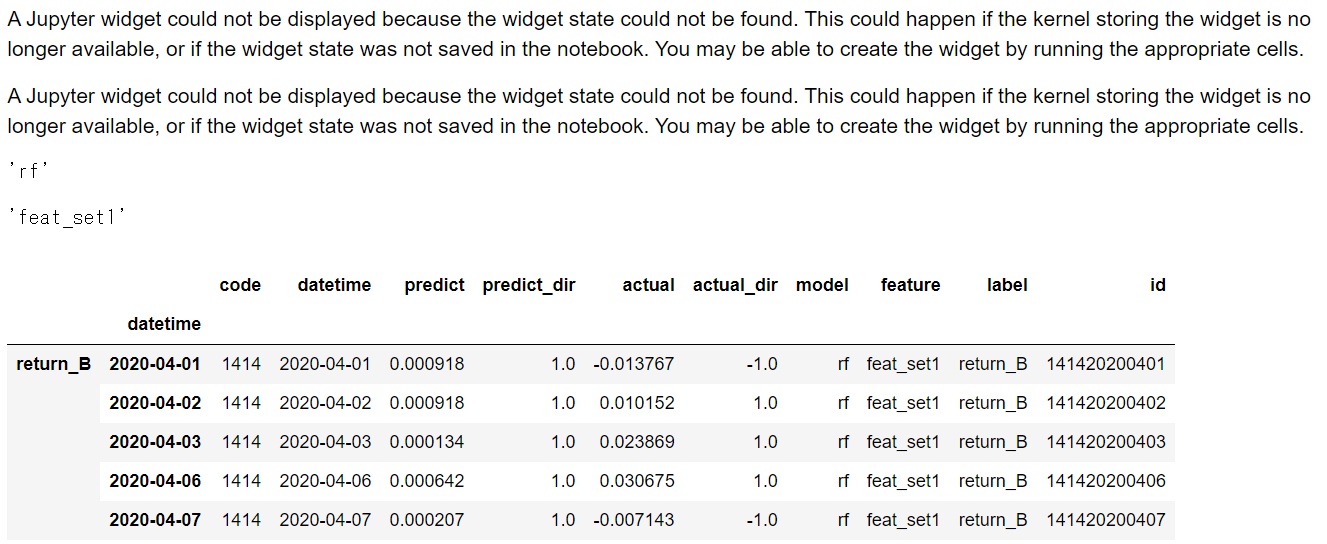

# 評価

In [ ]:
def calc_spread_return(df: pd.DataFrame, num_port: int = 100) -> float:    
    def _calc_spread_return_per_day(df):
        buf = df.sort_values(by="predict")
        purchase = buf.actual.iloc[-num_port:].mean()
        short = buf.actual.iloc[:num_port].mean()
        return purchase - short

    # 日付ごとにスプレッドリターンを計算します。
    buf = df.groupby("datetime").apply(_calc_spread_return_per_day)
    return buf

def evalulate_return(returns):
    ret = {}
    # 平均リターン
    # トレード1回あたりの平均の利益率を示します。合計損益を総トレード数で割ることで算出します。
    avg_return = returns.sum() / returns.shape[0]
    ret["avg_return"] = avg_return

    # 勝率
    # トレードがどの程度勝つかを示す指標です。勝ちトレード数 (利益が0を超えるトレード数) を総トレード数で割ることで算出します。
    win_ratio = returns.loc[returns > 0].shape[0] / returns.shape[0]
    ret["win_ratio"] = win_ratio

    # 最大ドローダウン
    # 累積リターンの最大地点からの下落率のことです。取引戦略のリスクを知る上で重要な指標です。
    max_drawdown = (returns.cumsum().cummax() - returns.cumsum()).max()
    ret["max_drawdown"] = max_drawdown

    # シャープレシオ
    # リスクに応じた利益を得られているかを示します。リターンから安全資産利回りを引いてそのリターンの標準偏差で割ることで算出します。
    # 週・月・年などの計算の単位で大きく結果が変わることに注意が必要です。
    # 日本株のアルゴリズムトレードの評価では、金利水準などを考慮し、安定資産利回りは0%で計算することが多いです。
    sharpe_ratio = returns.mean() / returns.std(ddof=1)
    ret["sharpe_ratio"] = sharpe_ratio

    return pd.DataFrame([ret])


matrix = dict()

buff = []
for feature, model, label, portsize in itertools.product(
    ["feat_set1"], # features_config.keys(),
    ["rf"], #models_config.keys(),
    ["return_B"], #labels_config.keys(),
    [5, 10, 20],
):
    print(feature, model, label, portsize)
    tmp_df = results[(results["model"] == model) & (results["label"] == label) & (results["feature"] == feature)].set_index("datetime")
    spread_return = calc_spread_return(tmp_df, portsize)
    df_eval = evalulate_return(spread_return)
    df_eval.loc[:, "model"] = model
    df_eval.loc[:, "portsize"] = portsize
    buff.append(df_eval)
    spread_return.cumsum().plot(figsize=(20, 8), legend=True, label=f"{feature} {model} {label} {portsize}", grid=True)

plt.show()
print(pd.concat(buff))

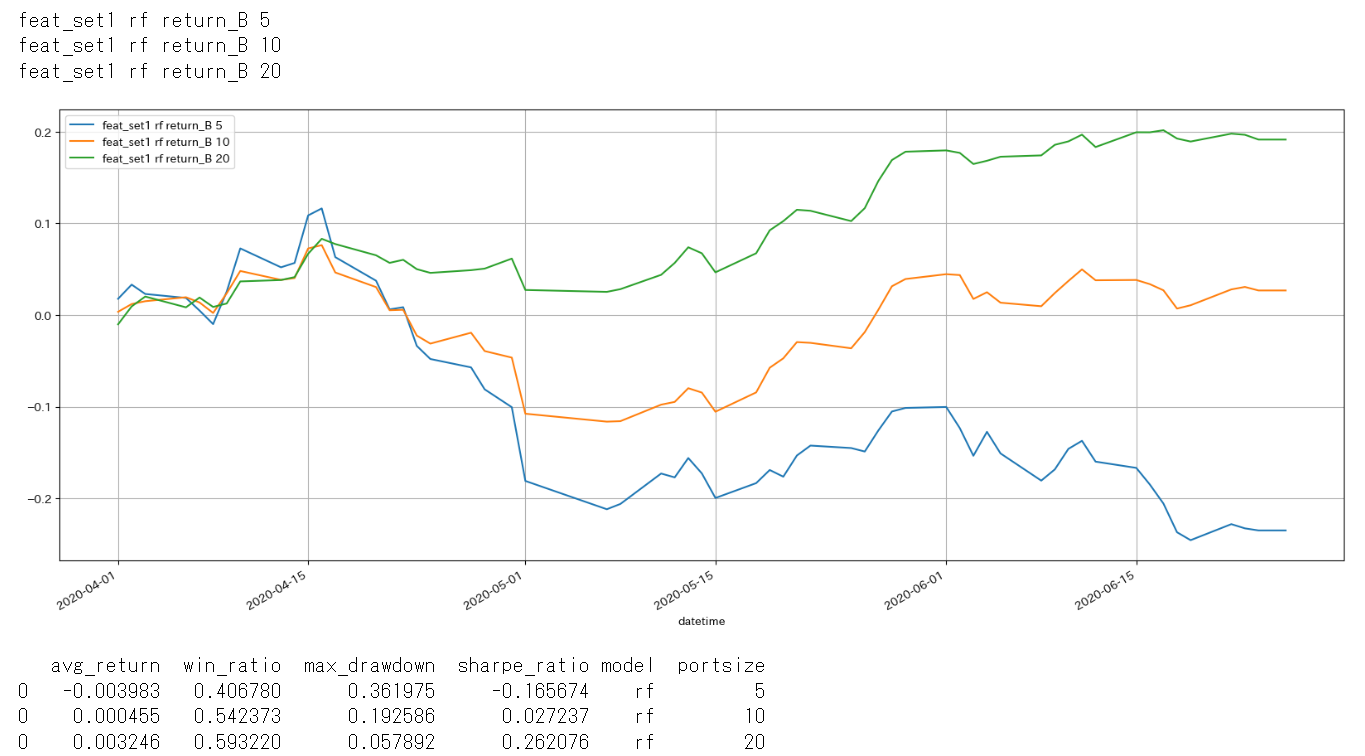

In [ ]:
# 特徴量設計とモデルにおける重要度（Importance）の関係

In [ ]:
t_cols = test_X[label][feat_cols].columns
# 重要度順を取得
sorted_idx = pred_model.feature_importances_.argsort()
# プロット
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(t_cols[sorted_idx], pred_model.feature_importances_[sorted_idx])
ax.set_xlabel("Feature Importance")
plt.show()

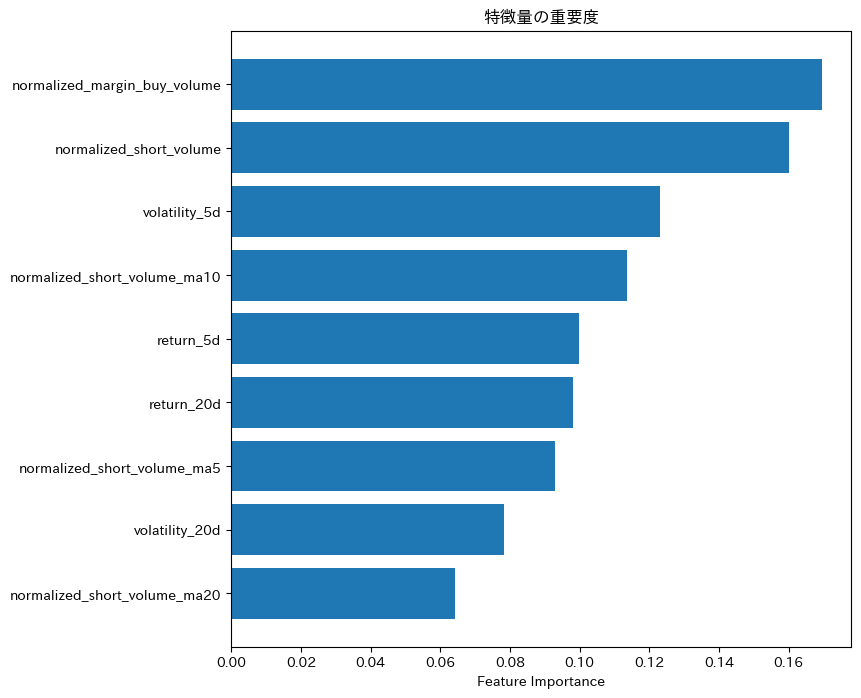